Sign Language Detection using LSTM

In [20]:
%pip install mediapipe tensorflow scikit-learn matplotlib opencv-python

Note: you may need to restart the kernel to use updated packages.


In [3]:
# Import Required Libraries
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import mediapipe as mp

In [4]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import TensorBoard
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score

In [5]:
# Initialize MediaPipe Holistic
mp_holistic = mp.solutions.holistic
mp_drawing = mp.solutions.drawing_utils

In [6]:
# Functions for Detection and Drawing
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # COLOR CONVERSION BGR 2 RGB
    image.flags.writeable = False                   # Image is no longer writeable
    results = model.process(image)                  # Make prediction
    image.flags.writeable = True
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    return image, results

In [7]:
# Extract Keypoint Values

def draw_styled_landmarks(image, results):
    # Draw face landmarks
    if results.face_landmarks:
        mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_CONTOURS,
                                  mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1), 
                                mp_drawing.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1))
    # Draw pose landmarks
    if results.pose_landmarks:
        mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                                  mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4), 
                              mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2))
    # Draw hand landmarks
    if results.left_hand_landmarks:
        mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                                  mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4), 
                              mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2))
    if results.right_hand_landmarks:
        mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                                  mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4), 
                              mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2))


In [8]:

def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([pose, face, lh, rh])


In [9]:
# Define Actions and Data Path
# actions 
actions = np.array(['hello', 'thanks', 'iloveyou','iamangry'])
# Path for Data Collection
DATA_PATH = os.path.join('MP_Data')
no_sequences = 30
sequence_length = 30

# Create Folders for Data Collection
for action in actions:
    for sequence in range(no_sequences):
        try:
            os.makedirs(os.path.join(DATA_PATH, action, str(sequence)))
        except:
            pass


In [ ]:

# Data Collection
cap = cv2.VideoCapture(0)
if not cap.isOpened():
    print("Error: Could not open camera.")
    exit()

stop_collection = False  # Flag to stop collection

# Access the MediaPipe Holistic model
with mp.solutions.holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    for action in actions:
        if stop_collection:
            break
        for sequence in range(no_sequences):
            if stop_collection:
                break
            for frame_num in range(sequence_length):
                ret, frame = cap.read()
                if not ret:
                    print("Error: Failed to capture frame.")
                    stop_collection = True
                    break

                image, results = mediapipe_detection(frame, holistic)
                if image is None or results is None:
                    print("Error: Mediapipe detection failed.")
                    stop_collection = True
                    break

                draw_styled_landmarks(image, results)

                if frame_num == 0:
                    cv2.putText(image, 'STARTING COLLECTION', (120, 200), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 4, cv2.LINE_AA)
                    cv2.putText(image, f'Collecting frames for {action} Video Number {sequence}', (15, 12), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    cv2.imshow('OpenCV Feed', image)
                    cv2.waitKey(500)
                else:
                    cv2.putText(image, f'Collecting frames for {action} Video Number {sequence}', (15, 12), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    cv2.imshow('OpenCV Feed', image)

                keypoints = extract_keypoints(results)
                npy_path = os.path.join(DATA_PATH, action, str(sequence), str(frame_num))
                np.save(npy_path, keypoints)

                # Check for 'Q' key press
                if cv2.waitKey(10) & 0xFF == ord('q'):
                    print("'Q' key pressed. Stopping collection.")
                    stop_collection = True
                    break

# Release the camera and close all OpenCV windows
cap.release()
cv2.destroyAllWindows()

In [10]:
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

NameError: name 'image' is not defined

Epoch 1/500
3/3 [==============================] - 6s 2s/step - loss: 1.4066 - categorical_accuracy: 0.2500 - val_loss: 1.4031 - val_categorical_accuracy: 0.4167
Epoch 2/500
3/3 [==============================] - 0s 153ms/step - loss: 1.3802 - categorical_accuracy: 0.4062 - val_loss: 1.3991 - val_categorical_accuracy: 0.4167
Epoch 3/500
3/3 [==============================] - 0s 145ms/step - loss: 1.3747 - categorical_accuracy: 0.3229 - val_loss: 1.3963 - val_categorical_accuracy: 0.1667
Epoch 4/500
3/3 [==============================] - 0s 145ms/step - loss: 1.3681 - categorical_accuracy: 0.3646 - val_loss: 1.3874 - val_categorical_accuracy: 0.4167
Epoch 5/500
3/3 [==============================] - 0s 155ms/step - loss: 1.3593 - categorical_accuracy: 0.4479 - val_loss: 1.3748 - val_categorical_accuracy: 0.4167
Epoch 6/500
3/3 [==============================] - 0s 158ms/step - loss: 1.3451 - categorical_accuracy: 0.4375 - val_loss: 1.3645 - val_categorical_accuracy: 0.4167
Epoch 7/500
3

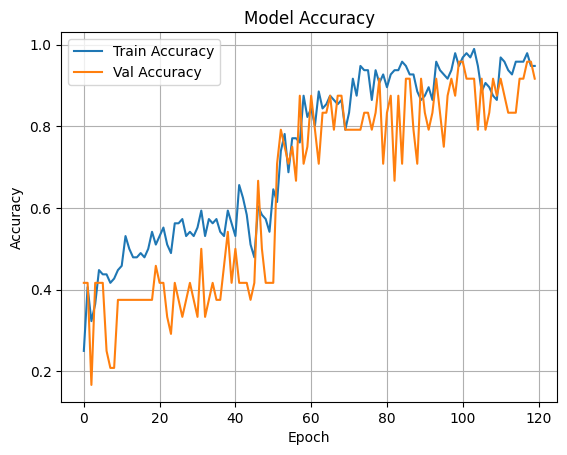

In [ ]:

from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping
from tensorflow.keras.optimizers import Adam


# Actions & Paths
actions = np.array(['hello', 'thanks', 'iloveyou', 'iamangry'])  # Replace with your action list
DATA_PATH = os.path.join('MP_Data')  # Update if your path is different
no_sequences = 30
sequence_length = 30

# Label Map
label_map = {label: num for num, label in enumerate(actions)}

# Load Sequences and Labels
sequences, labels = [], []
for action in actions:
    for sequence in range(no_sequences):
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(DATA_PATH, action, str(sequence), f"{frame_num}.npy"))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])

# Preprocess
X = np.array(sequences)
y = to_categorical(labels).astype(int)

# Train-Test Split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build Fine-Tuned Model
model = Sequential()
model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(30, 1662)))
model.add(Dropout(0.3))
model.add(LSTM(128, return_sequences=True, activation='relu'))
model.add(Dropout(0.3))
model.add(LSTM(64, return_sequences=False, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(actions.shape[0], activation='softmax'))

# Compile Model
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['categorical_accuracy']
)

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
log_dir = os.path.join('Logs')

# Train Model
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=500,
    callbacks=[TensorBoard(log_dir=log_dir), early_stop]
)

# Evaluate
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy * 100:.2f}%, Loss: {loss:.4f}")

# Save Model
model.save('action.h5')


# Plot Training and Validation Accuracy
plt.plot(history.history['categorical_accuracy'], label='Train Accuracy')
plt.plot(history.history['val_categorical_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.grid()
plt.show()



In [1]:
model.summary()

NameError: name 'model' is not defined

In [ ]:
# Evaluate Model
y_pred = model.predict(X_test)
y_true = np.argmax(y_test, axis=1).tolist()
y_pred = np.argmax(y_pred, axis=1).tolist()

print("Confusion Matrix:\n", multilabel_confusion_matrix(y_true, y_pred))
print("Accuracy:", accuracy_score(y_true, y_pred))


SyntaxError: (unicode error) 'unicodeescape' codec can't decode bytes in position 2-3: truncated \UXXXXXXXX escape (3812525475.py, line 2)

In [7]:
colors = [(245,117,16), (117,245,16), (16,117,245)]
def prob_viz(res, actions, input_frame, colors):
    output_frame = input_frame.copy()
    for num, prob in enumerate(res):
        cv2.rectangle(output_frame, (0,60+num*40), (int(prob*100), 90+num*40), colors[num], -1)
        cv2.putText(output_frame, actions[num], (0, 85+num*40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
        
    return output_frame

In [ ]:
# plt.figure(figsize=(18,18))
# plt.imshow(prob_viz(res, actions, image, colors))

NameError: name 'image' is not defined

<Figure size 1800x1800 with 0 Axes>

In [ ]:
# 1. New detection variables
sequence = []
sentence = []
predictions = []
threshold = 0.5

cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        print(results)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)
        
        # 2. Prediction logic
        keypoints = extract_keypoints(results)
        sequence.append(keypoints)
        sequence = sequence[-30:]
        
        if len(sequence) == 30:
            res = model.predict(np.expand_dims(sequence, axis=0))[0]
            print(actions[np.argmax(res)])
            predictions.append(np.argmax(res))
            
            
        #3. Viz logic
            if len(predictions) >= 10 and np.unique(predictions[-10:])[0] == np.argmax(res): 
                if res[np.argmax(res)] > threshold: 
                    
                    if len(sentence) > 0: 
                        if actions[np.argmax(res)] != sentence[-1]:
                            sentence.append(actions[np.argmax(res)])
                    else:
                        sentence.append(actions[np.argmax(res)])

            if len(sentence) > 5: 
                sentence = sentence[-5:]

            # Viz probabilities
            image = prob_viz(res, actions, image, colors)
            
        cv2.rectangle(image, (0,0), (640, 40), (245, 117, 16), -1)
        cv2.putText(image, ' '.join(sentence), (3,30), 
                       cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        
        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

NameError: name 'model' is not defined

: 

In [25]:
cap.release()
cv2.destroyAllWindows()